In [1]:
import PyDSTool as dst
from PyDSTool import args
import numpy as np
from matplotlib import pyplot as plt

pars = {'eps': 1e-2, 'a': 0.5}
icdict = {'x': pars['a'],
          'y': pars['a'] - pars['a']**3/3}
xstr = '(y - (x*x*x/3 - x))/eps'
ystr = 'a - x'

event_x_a = dst.makeZeroCrossEvent('x-a', 0,
                            {'name': 'event_x_a',
                             'eventtol': 1e-6,
                             'term': False,
                             'active': True},
                    varnames=['x'], parnames=['a'],
                    targetlang='python')  # targetlang is redundant (defaults to python)

DSargs = args(name='vanderpol')  # struct-like data
DSargs.events = [event_x_a]
DSargs.pars = pars
DSargs.tdata = [0, 3]
DSargs.algparams = {'max_pts': 3000, 'init_step': 0.02, 'stiff': True}
DSargs.varspecs = {'x': xstr, 'y': ystr}
DSargs.xdomain = {'x': [-2.2, 2.5], 'y': [-2, 2]}
DSargs.fnspecs = {'Jacobian': (['t','x','y'],
                                """[[(1-x*x)/eps, 1/eps ],
                                    [    -1,        0   ]]""")}
DSargs.ics = icdict
vdp = dst.Vode_ODEsystem(DSargs)

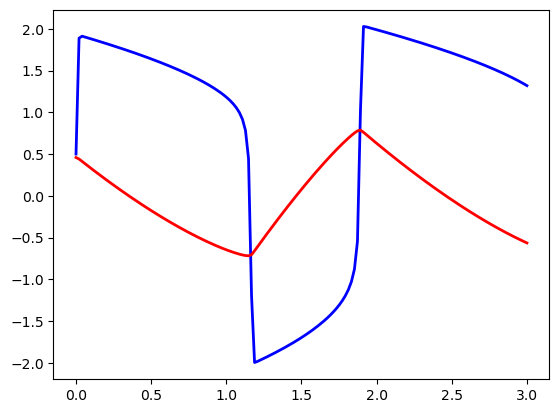

In [2]:
traj = vdp.compute('test_traj')
pts = traj.sample()
evs = traj.getEvents('event_x_a')

# figure 1 is the time evolution of the two variables
plt.figure(1)
plt.plot(pts['t'], pts['x'], 'b', linewidth=2)
plt.plot(pts['t'], pts['y'], 'r', linewidth=2)

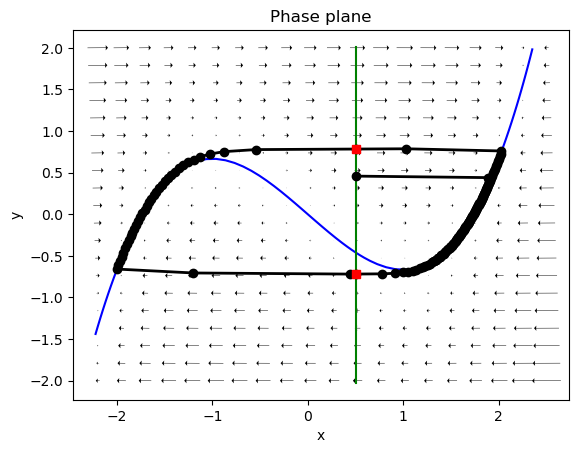

In [3]:
plt.figure(2)
# phase plane tools are in the Toolbox module
from PyDSTool.Toolbox import phaseplane as pp

# plot vector field, using a scale exponent to ensure arrows are well spaced
# and sized
pp.plot_PP_vf(vdp, 'x', 'y', scale_exp=-1)

# only one fixed point, hence [0] at end.
# n=4 uses three starting points in the domain to find any fixed points, to an
# accuracy of eps=1e-8.
fp_coord = pp.find_fixedpoints(vdp, n=4, eps=1e-8)[0]
fp = pp.fixedpoint_2D(vdp, dst.Point(fp_coord), eps=1e-8)

# n=3 uses three starting points in the domain to find nullcline parts, to an
# accuracy of eps=1e-8, and a maximum step for the solver of 0.1 units.
# The fixed point found is also provided to help locate the nullclines.
nulls_x, nulls_y = pp.find_nullclines(vdp, 'x', 'y', n=3, eps=1e-8, max_step=0.1,
                             fps=[fp_coord])

# plot the fixed point
pp.plot_PP_fps(fp)

# plot the nullclines
plt.plot(nulls_x[:,0], nulls_x[:,1], 'b')
plt.plot(nulls_y[:,0], nulls_y[:,1], 'g')

# plot the trajectory
plt.plot(pts['x'], pts['y'], 'k-o', linewidth=2)

# plot the event points
plt.plot(evs['x'], evs['y'], 'rs')

plt.axis('tight')
plt.title('Phase plane')
plt.xlabel('x')
plt.ylabel('y')

# you may not need to run this command on your system
plt.show()

In [6]:
""" EXAMPLE: "New" Lorenz system found in [4], p. 374, Exercise 8.7.12
Also in [3], p. 153, Exercise 5.6.18

    Drew LaMar, December 2005
"""

from PyDSTool import *

pars = {'p1': 280., 'p2': 8./3., 'p3': 10.}

icdict = {'u1': 0.0, 'u2': 0.0, 'u3': 0.0}

# Set up model
u1str = 'p3*(u2 - u1)'
u2str = 'p1*u1 - u2 - u1*u3'
u3str = 'u1*u2 - p2*u3'

DSargs = args(name='Lorenz')
DSargs.fnspecs = {'Jacobian': (['t', 'u1', 'u2', 'u3'],
                        """[[-1*p3, p3, 0.0],
                            [p1-u3, -1.0, -1*u1],
                            [u2, u1, -1*p2]]""")}
                  #'Jacobian_pars': (['t', 'p1', 'p2', 'p3'],
                  #      """[[0.0, 0.0, u2-u1],
                  #          [u1, 0.0, 0.0],
                  #          [0.0, -1*u3, 0.0]]""")}
DSargs.pars = pars
DSargs.varspecs = {'u1': u1str, 'u2': u2str, 'u3': u3str}
DSargs.ics = icdict

testDS = Generator.Vode_ODEsystem(DSargs)

# Set up continuation class
PyCont = ContClass(testDS)

# Read cycle data from lor.dat
cycle=transpose(importPointset('../PyCont/auto/demos/lor/lor.dat'))

# Set up continuation parameters
PCargs = args(name='LC1', type='LC-C')
PCargs.freepars = ['p1']
PCargs.StepSize = 0.5
PCargs.MinStepSize = 0.01
PCargs.MaxStepSize = 25.0
PCargs.NumCollocation = 4
PCargs.NumIntervals = 20
PCargs.initcycle = cycle
PCargs.SolutionMeasures = 'all'
PCargs.LocBifPoints = 'all'
PCargs.FuncTol = 1e-7
PCargs.VarTol = 1e-7
PCargs.TestTol = 1e-4
PCargs.MaxNumPoints = 70
PCargs.SaveJacobian = True
PyCont.newCurve(PCargs)

print("Beginning computation of curve in backward and then forward direction...")
start = clock()
PyCont['LC1'].backward()
PyCont['LC1'].update({'MaxNumPoints': 90, 'NumSPOut': 90})
PyCont['LC1'].forward()
print("\nComputation complete in %.3f seconds.\n" % (clock()-start))

# Plot
PyCont['LC1'].cleanLabels()
PyCont['LC1'].display(stability=True, axes=(1,2,1))
PyCont['LC1'].plot_cycles(cycles=['P1', 'PD1', 'LPC1'], coords=('u1','u2'), color_method='bytype', linewidth=1, axes=(1,2,2))
PyCont['LC1'].plot_cycles(cycles=['PD2', 'P2'], coords=('u1','u2'), color_method='bytype', linestyle='--', linewidth=1, axes=(1,2,2))
plt.legend(loc=2)

PyCont.plot.fig1.axes1.axes.set_title('Bifurcation Diagram')
PyCont.plot.fig1.axes1.axes.set(xlim=(50, 375), ylim=(14, 50))

PyCont.plot.fig1.axes2.axes.set_title('Cycles')
X = array(PyCont.plot.fig1.axes2.axes.get_position()).flatten()
PyCont.plot.fig1.axes2.axes.set_position((X[0]*1.05, X[1], X[2], X[3]))

PyCont.plot.refresh()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '../PyCont/auto/demos/lor/lor.dat'

Computing equilibrium curve...
Maximum test function iterations reached.

Checking...
  |q| = 1.000000
  |<p,q> - 1| =  0.0
  |Aq - iwq| = 0.000000
  |A*p + iwp| = 0.000000

H Point found 
0 : 
x  =  1.000000015166198
y  =  0.0
z  =  0.0
F  =  1.000000015166198

Eigenvalues = 

     (0.000000,4.000000)
     (0.000000,-4.000000)
     (-0.250000,0.000000)


w = 4.000000060664792
l1 = -7.999999999925314

Computing hopf curve...


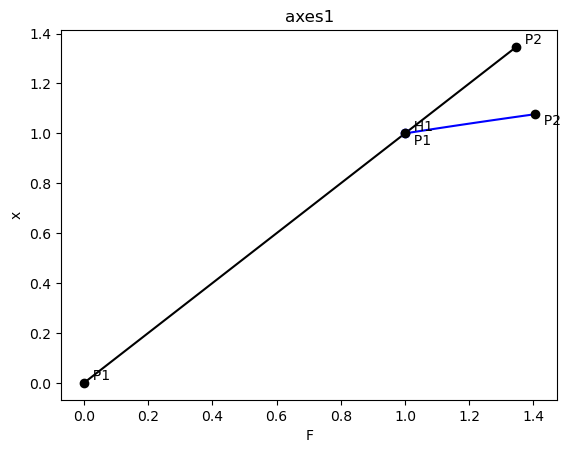

In [13]:
""" EXAMPLE: "New" Lorenz system found in [4], p. 374, Exercise 8.7.12
	Also in [3], p. 153, Exercise 5.6.18

    Drew LaMar, December 2005
"""

from PyDSTool import *

pars = {'a': 0.25,'b': 4.0,'F': 0.0,'G': 0.0}

icdict = {'x': 0.0,'y': 0.0,'z': 0.0}

# Set up model
xstr = '-y*y - z*z - a*x + a*F'
ystr = 'x*y - b*x*z - y + G'
zstr = 'b*x*y + x*z - z'

DSargs = args(name='NewLorenz')
DSargs.pars = pars
DSargs.varspecs = {'x': xstr, 'y': ystr, 'z': zstr}
DSargs.ics = icdict

testDS = Generator.Vode_ODEsystem(DSargs)

# Set up continuation class
PyCont = ContClass(testDS)

PCargs = args(name='EQ1', type='EP-C')
PCargs.freepars = ['F']
PCargs.StepSize = 1e-3
PCargs.MaxNumPoints = 200
PCargs.MaxStepSize = 1e-2
PCargs.LocBifPoints = 'H'
PCargs.verbosity = 2
PyCont.newCurve(PCargs)

print('Computing equilibrium curve...')
PyCont['EQ1'].forward()

# Hopf curve
PCargs = args(name='HO1', type='H-C2')
PCargs.initpoint = 'EQ1:H1'
PCargs.freepars = ['F','G']
PCargs.MaxNumPoints = 40

PyCont.newCurve(PCargs)

print('Computing hopf curve...')
PyCont['HO1'].forward()

# Plot
PyCont.display(('F','x'))
plt.show()
